<a href="https://colab.research.google.com/github/Adas68/Ontario_Electricity_Forecasting/blob/main/AISE_4010_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ontario Electricity Demand Forecasting
Group 2: Apon Das, Ritwick Vemula, Rayyan Nezami
Course: AISE4010 – Deep Learning for Time Series

This notebook forecasts hourly electricity demand in Ontario (2025) using deep learning.
We compare an LSTM model against a naive baseline (same hour yesterday).
All code is self-contained — just upload your PUB_Demand.csv.xlsx and run!

🔧 Installing and importing libraries...

📂 Loading data from 'PUB_Demand.csv.xlsx' (already in Colab)
🧹 Cleaning data...
✅ Data range: 2025-01-01 01:00:00 → 2025-09-20 01:00:00
📊 Train samples: 4342 | Test samples: 1946
🔁 Sequences → Train: (4318, 24, 5), Test: (1922, 24, 5)

🧠 Training LSTM model (20 epochs)...

✅ FINAL RESULTS
📈 LSTM      → MAE: 618.58 MW | RMSE: 766.88 MW
🧱 Baseline  → MAE: 844.58 MW | RMSE: 1171.50 MW


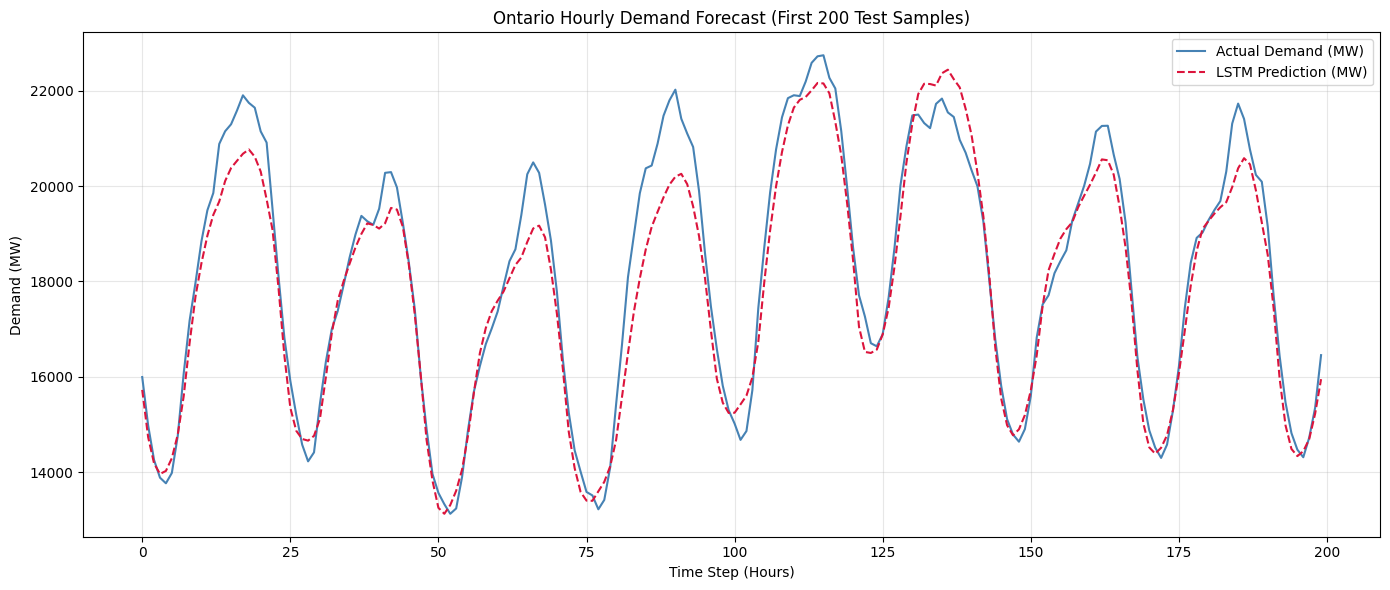


🎉 Done! The plot above shows actual vs. predicted demand.


In [30]:
# Ontario Electricity Demand Forecasting - FINAL Google Colab Version
# Group 2: Apon Das, Ritwick Vemula, Xander Chin, Rayyan Nezami
# Course: AISE4010

# 1. INSTALL & IMPORT (run once)
print("🔧 Installing and importing libraries...")
!pip install -q pandas openpyxl matplotlib scikit-learn tensorflow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# 2. LOAD DATA FROM ALREADY UPLOADED FILE
print("\n📂 Loading data from 'PUB_Demand.csv.xlsx' (already in Colab)")
try:
    # This will work if you've already uploaded the file
    df_raw = pd.read_excel('PUB_Demand.csv.xlsx', header=None)
except FileNotFoundError:
    raise FileNotFoundError("❌ File 'PUB_Demand.csv.xlsx' not found. Please upload it to Colab first.")

print("🧹 Cleaning data...")

# Keep only rows where column 1 (Hour) is numeric → skips metadata like "\\Hourly Demand Report"
df_clean = df_raw[pd.to_numeric(df_raw.iloc[:, 1], errors='coerce').notnull()]
df_clean = df_clean.dropna().reset_index(drop=True)
df_clean.columns = ['Date', 'Hour', 'Market_Demand', 'Ontario_Demand']
df_clean['Hour'] = df_clean['Hour'].astype(int)

# Handle Hour=24 → convert to 00:00 next day
df_clean['Hour_adj'] = df_clean['Hour'].replace(24, 0)
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['DateTime'] = pd.to_datetime(
    df_clean['Date'].astype(str) + ' ' + df_clean['Hour_adj'].astype(str).str.zfill(2) + ':00:00'
)
df_clean.loc[df_clean['Hour'] == 24, 'DateTime'] += pd.Timedelta(days=1)

df_clean.set_index('DateTime', inplace=True)
data = df_clean[['Ontario_Demand']].astype(float).copy()

# Add time features
data['HourOfDay'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['IsWeekend'] = (data.index.dayofweek >= 5).astype(int)

print(f"✅ Data range: {data.index.min()} → {data.index.max()}")

# 3. SPLIT DATA
train_data = data.loc[:'2025-06-30 23:00:00']
test_data = data.loc['2025-07-01 00:00:00':'2025-09-30 23:00:00']

print(f"📊 Train samples: {len(train_data)} | Test samples: {len(test_data)}")

if len(test_data) == 0:
    raise ValueError("❌ No test data! Check your date range.")

# 4. PREPARE FEATURES & SCALE
feature_cols = ['Ontario_Demand', 'HourOfDay', 'DayOfWeek', 'Month', 'IsWeekend']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[feature_cols])
test_scaled = scaler.transform(test_data[feature_cols])

# 5. CREATE SEQUENCES (24 hours → predict next hour)
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

print(f"🔁 Sequences → Train: {X_train.shape}, Test: {X_test.shape}")

# 6. BUILD & TRAIN LSTM MODEL
print("\n🧠 Training LSTM model (20 epochs)...")
model = Sequential([
    LSTM(32, activation='relu', input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# 7. EVALUATE: LSTM vs. NAIVE BASELINE
def inverse_transform_ontario(scaler, y_array, n_features):
    dummy = np.zeros((len(y_array), n_features))
    dummy[:, 0] = y_array
    return scaler.inverse_transform(dummy)[:, 0]

y_pred = model.predict(X_test, verbose=0).flatten()
y_pred_inv = inverse_transform_ontario(scaler, y_pred, len(feature_cols))
y_test_inv = inverse_transform_ontario(scaler, y_test, len(feature_cols))

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Baseline: Predict same hour from yesterday (24 hours ago)
baseline_pred = test_data['Ontario_Demand'].shift(24).dropna().values
baseline_true = test_data['Ontario_Demand'][24:].values
mae_baseline = mean_absolute_error(baseline_true, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(baseline_true, baseline_pred))

# 8. DISPLAY RESULTS (NO FILES SAVED, ALL ON SCREEN)
print("\n✅ FINAL RESULTS")
print(f"📈 LSTM      → MAE: {mae_lstm:.2f} MW | RMSE: {rmse_lstm:.2f} MW")
print(f"🧱 Baseline  → MAE: {mae_baseline:.2f} MW | RMSE: {rmse_baseline:.2f} MW")

# PLOT FIRST 200 SAMPLES
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[:200], label='Actual Demand (MW)', color='steelblue')
plt.plot(y_pred_inv[:200], label='LSTM Prediction (MW)', color='crimson', linestyle='--')
plt.title('Ontario Hourly Demand Forecast (First 200 Test Samples)')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎉 Done! The plot above shows actual vs. predicted demand.")